LSTM that predicts upwards and downwards trend of google stockprice 
Many layers with dropout regularisation to prevent overfitting

Part 1 - Data Preprocessing

In [1]:
# Importing the libraries
import numpy as np #allow to make arrays
import matplotlib.pyplot as plt #visualize results on charts 
import pandas as pd #import dataset and manage easily

In [2]:
# Importing the training set - only importing training set, test set later  on 
#rnn has no idea of the test set's data, then after training is done, test set will eb important
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')

#need to make into numpy arrays because only nump arrays can be input values in keras
training_set = dataset_train.iloc[:, 1:2].values 

#getting everything from the columns (.values makes the numpy array)

Text(0, 0.5, 'High')

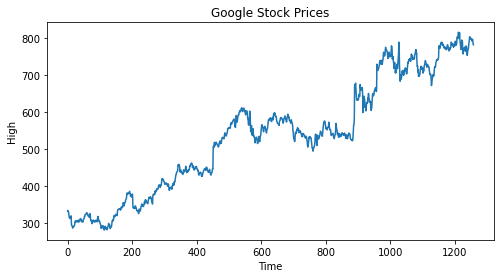

In [3]:
plt.figure(figsize=(8,4))
plt.plot(dataset_train['High'])
plt.title("Google Stock Prices")
plt.xlabel('Time')
plt.ylabel('High')

In [4]:
# Feature Scaling
#2 ways: take obs- min ofstock prices/max of stock prices- min of stock prices
#using normalization instead of standardisation- look at meaning
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set) #fit (gets min and max on data to apply formula) tranform(compute scale stock prices to each formula)

In [5]:
training_set_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

In [6]:
# Creating a data structure with 60 timesteps and 1 output
#60 times steps- at each time t and look at 60 previous time steps, then make new prediction 
# 1 time step leads to overfitting, 20 is still too low
#60 previous financial days- in 3 months 
X_train = []
y_train = []
for i in range(60, 1258): # upper bound is number of values 
    X_train.append(training_set_scaled[i-60:i, 0]) #takes 60 previous stock prices from 60 past stock prices
    y_train.append(training_set_scaled[i, 0]) #contains stock price learned to predict 
X_train, y_train = np.array(X_train), np.array(y_train) # make into numpy arrays 
#Need to add dimension to because not only prescition with one stock price but other indicators (like other columns in dataset  or other stocks that may affect this one )

In [7]:
# Reshaping- add dimension in numpy array 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #adds dimension in numpy array
#currently only have one indicator, with new dimension will have more indicators, be compatible for "input shape" of RNN
# format according to keras documentation 


Part 2 - Building the RNN 
stacked lstm with dropout regularization to prevent overfitting

In [8]:
# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [9]:
# Initialising the RNN
regressor = Sequential() #reps sequence of layers, predicting continous values (so it is a regression)

In [10]:
# Adding the first LSTM layer and some Dropout regularisation
#dropout to prevent overfitting
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))#regressor- object of sequential class, can add layers to networ.
#use lstm class and create object of lstm class- 3 args
#num of units, return sequences- set to true because is stacked lstms, and shape
#units- neurons in first layer. 50 in layers for high dimensionality, can capture upward and downward
regressor.add(Dropout(0.2))
# takes arg of dropout late- num of neurons want to drop. dropping 20% of neurons to be ignored during trianingn for each iteratin. 10 neurons will be dropped out

In [11]:
# Adding a second LSTM layer and some Dropout regularisation
# total of 4 layers, simply need to copy, only change is input shape so dont need to specify that, automatically recognised through input shape

regressor.add(LSTM(units = 50, return_sequences = True)) 

regressor.add(Dropout(0.2))

In [12]:
# Adding a third LSTM layer and some Dropout regularisation
# same as second layer 
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [13]:
# Adding a fourth LSTM layer and some Dropout regularisation
# almost same, but return sequence is false because it is the last lstm layer (so it is removed becasue default is false)
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [14]:
# Adding the output layer
#add fully connected layer through dense class- dimesion/units/neurons is 1
regressor.add(Dense(units = 1))

In [15]:
# Compiling the RNN
#regressior because predicting continuous value, 
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [16]:
# Fitting the RNN to the Training set
#have not made connection to training set, training will take place
regressor.fit(X_train, y_train, epochs = 50, batch_size = 32) # CHANGE BACK TO 100 IF NOT WORK
#100 gives good convergence
# trained on certain batch sizes,

Epoch 1/50
38/38 [==============================] - 20s 136ms/step - loss: 0.0926
Epoch 2/50
38/38 [==============================] - 5s 139ms/step - loss: 0.0071
Epoch 3/50
38/38 [==============================] - 6s 151ms/step - loss: 0.0055
Epoch 4/50
38/38 [==============================] - 6s 155ms/step - loss: 0.0051
Epoch 5/50
38/38 [==============================] - 6s 154ms/step - loss: 0.0051
Epoch 6/50
38/38 [==============================] - 6s 145ms/step - loss: 0.0048
Epoch 7/50
38/38 [==============================] - 6s 149ms/step - loss: 0.0054
Epoch 8/50
38/38 [==============================] - 5s 136ms/step - loss: 0.0047
Epoch 9/50
38/38 [==============================] - 5s 125ms/step - loss: 0.0053
Epoch 10/50
38/38 [==============================] - 5s 128ms/step - loss: 0.0043
Epoch 11/50
38/38 [==============================] - 5s 124ms/step - loss: 0.0040
Epoch 12/50
38/38 [==============================] - 5s 119ms/step - loss: 0.0045
Epoch 13/50
38/38 [=====

Part 3 - Making the predictions and visualising the results

In [17]:
# Getting the real stock price of 2018
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [18]:
# Getting the predicted stock price of 2018
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values #getting input of each previous financial days
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [19]:
inputs.shape

(80, 1)

In [20]:
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

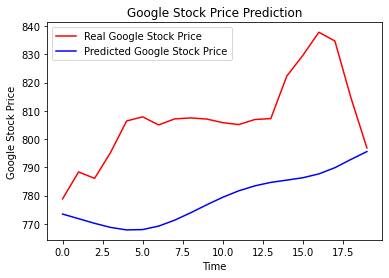

In [21]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()